O objetivo desse projeto é desenvolver um modelo de CNN que possa detectar anomalias em um conjunto de dados de
imagens médicas. O modelo deve ser capaz de identificar e localizar a anomalia na imagem,
bem como classificar o tipo de anomalia.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from itertools import chain

In [ ]:
path = '/content/samples/'

data = pd.read_csv(path + 'Data_Entry_2017_v2020.csv')
data.sample(6)

Image Index         Finding Labels  Follow-up #  Patient ID  \
61954  00015326_002.png  Effusion|Infiltration            1       15326   
66905  00016531_000.png             No Finding            0       16531   
72865  00017961_010.png             No Finding            4       17961   
91668  00022857_006.png             No Finding            6       22857   
60474  00014933_003.png             No Finding            3       14933   
61687  00015239_007.png             No Finding            7       15239   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
61954           39              F            PA                 2992     2991   
66905           52              M            PA                 2992     2991   
72865           47              M            AP                 2500     2048   
91668           35              F            PA                 2992     2991   
60474           54              F            AP                 2500     2048   
61687           16              F            PA                 1752     1964   

       OriginalImagePixelSpacing[x        y]  
61954                     0.143000  0.143000  
66905                     0.143000  0.143000  
72865                     0.168000  0.168000  
91668                     0.143000  0.143000  
60474                     0.168000  0.168000  
61687                     0.194311  0.194311

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [ ]:
data.isnull().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64

Data set não possui nenhum campo nulo. Logo, não é necessário fazer uma limpeza nesse sentido.

In [ ]:
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)


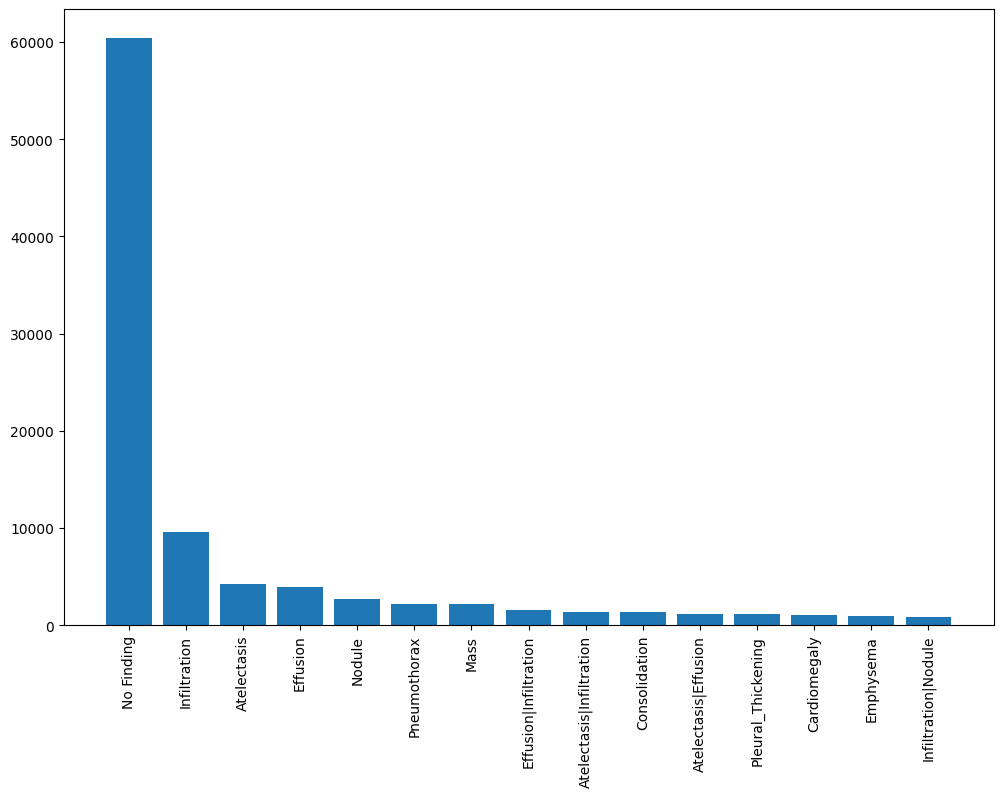

In [ ]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

Existe uma alta quantidade de amostras que não encontraram doenças, para viés de treinamento é interessante mantermos apenas as amostras com doenças.

In [ ]:
data = data[data['Finding Labels'] != 'No Finding']

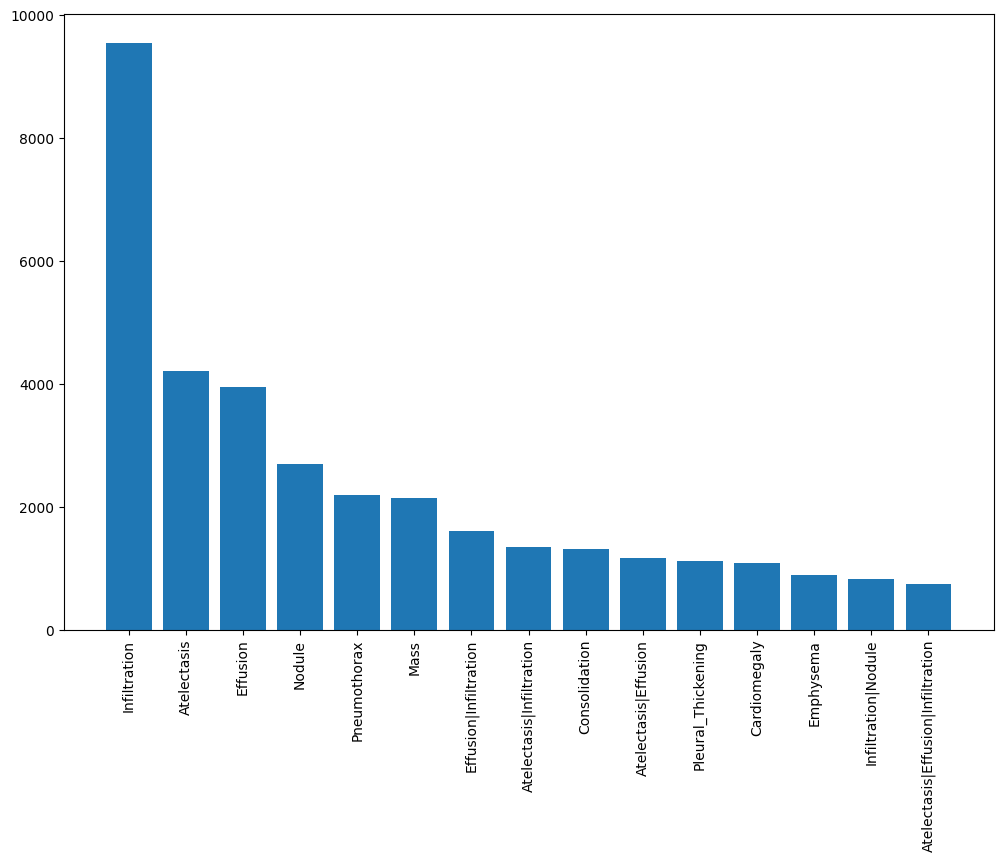

In [ ]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

Existem imagens com mais de uma doença, necessário realizar a separação das doenças presentes nesses casos.

In [ ]:
novas_linhas = []

for indice, linha in data.iterrows():
    valores_separados = linha['Finding Labels'].split('|')

    for valor_separado in valores_separados:
        nova_linha = linha.copy()
        nova_linha['Finding Labels'] = valor_separado
        novas_linhas.append(nova_linha)

dados_modificados = pd.DataFrame(novas_linhas)

dados_modificados.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
1  00000001_001.png   Cardiomegaly            1           1           58   
1  00000001_001.png      Emphysema            1           1           58   
2  00000001_002.png   Cardiomegaly            2           1           58   
2  00000001_002.png       Effusion            2           1           58   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2894     2729   
1              M            PA                 2894     2729   
2              M            PA                 2500     2048   
2              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Labels_Count  
0                        0.143  0.143             1  
1                        0.143  0.143             2  
1                        0.143  0.143             2  
2                        0.168  0.168             2  
2                        0.168  0.168             2

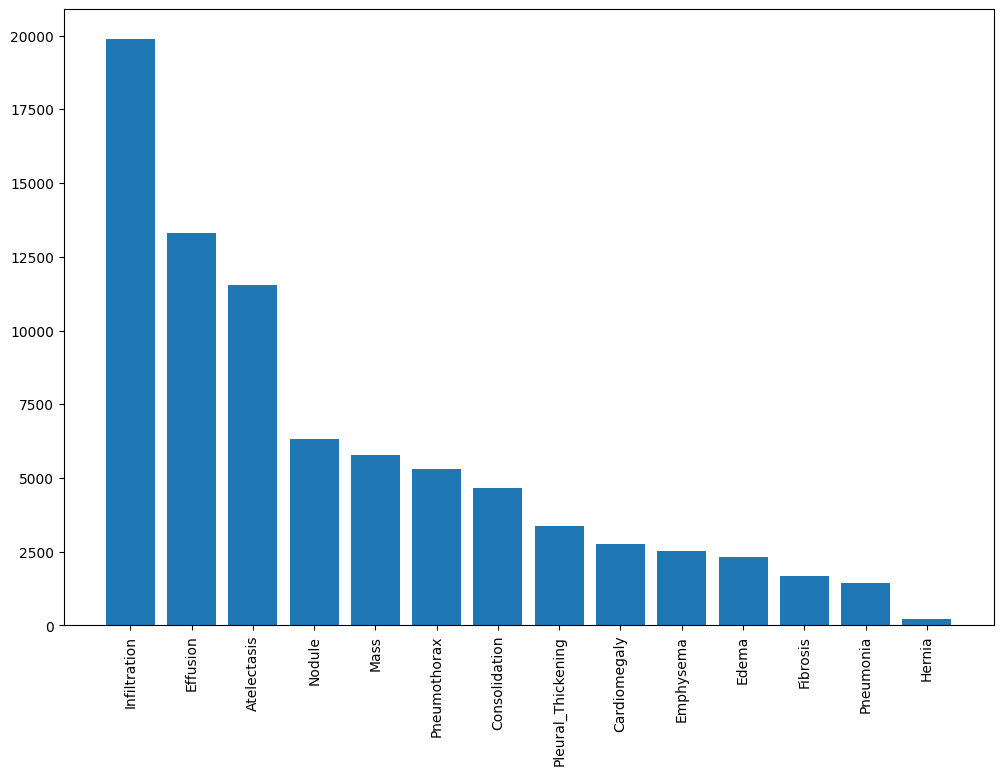

In [ ]:
label_counts = dados_modificados['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

Após tratarmos os dados do csv que contém o detalhamento dos dados será o momento de trabalharmos com as imagens, começando com o download delas.

In [ ]:
#!/usr/bin/env python3
# Download the 56 zip files in Images_png in batches
import urllib.request
import tarfile

links = [
     'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading '+fn+'...')
    urllib.request.urlretrieve(link, fn)
    print('decompressing '+fn+'...')
    img_zip = tarfile.open('/content/'+fn)
    img_zip.extractall('/content/samples')
    img_zip.close()

print("Download completo.")

downloading images_01.tar.gz...


KeyboardInterrupt: ignored

Devido ao tempo de execução e espaço da máquina virtual, nem todas as imagens foram baixadas, logo é necessário filtramos os dados para mantermos apenas os dados referentes as que foram baixadas.

In [ ]:
import os
def check_img(name):

  return os.path.isfile(os.path.join('/content/samples/images',name))


dados_modificados['IMG baixada'] = dados_modificados['Image Index'].apply(check_img)
print('Downloads verificados')

dados_modificados.head()

Downloads verificados


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
1  00000001_001.png   Cardiomegaly            1           1           58   
1  00000001_001.png      Emphysema            1           1           58   
2  00000001_002.png   Cardiomegaly            2           1           58   
2  00000001_002.png       Effusion            2           1           58   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2894     2729   
1              M            PA                 2894     2729   
2              M            PA                 2500     2048   
2              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Labels_Count  IMG baixada  
0                        0.143  0.143             1         True  
1                        0.143  0.143             2         True  
1                        0.143  0.143             2         True  
2                        0.168  0.168             2         True  
2                        0.168  0.168             2         True

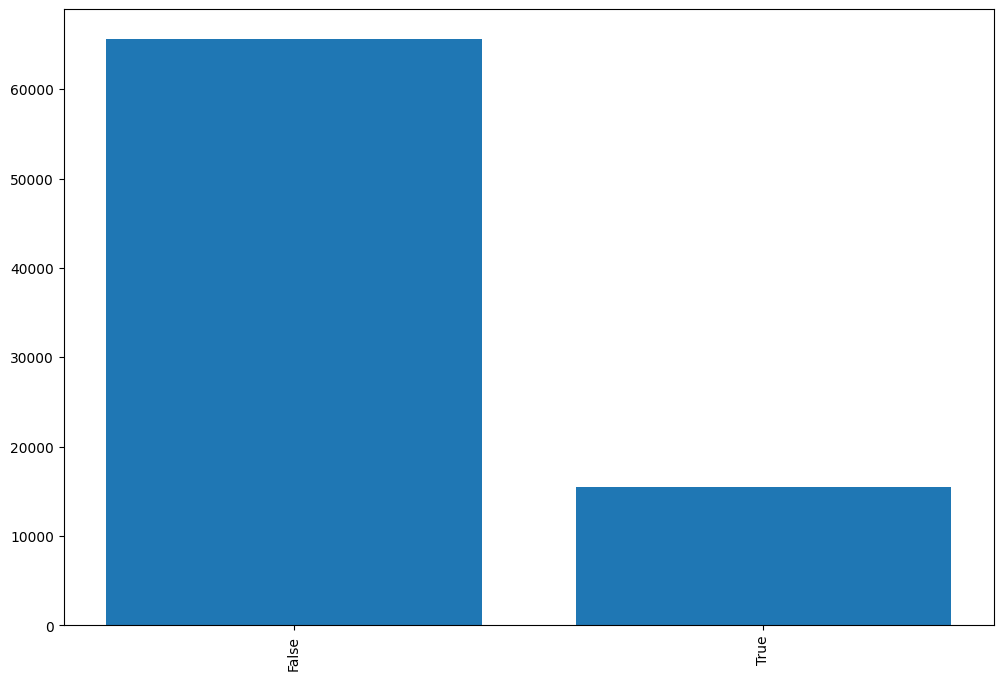

In [ ]:
label_counts = dados_modificados['IMG baixada'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
dados_modificados = dados_modificados[dados_modificados['IMG baixada'] != False]
dados_modificados.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
1  00000001_001.png   Cardiomegaly            1           1           58   
1  00000001_001.png      Emphysema            1           1           58   
2  00000001_002.png   Cardiomegaly            2           1           58   
2  00000001_002.png       Effusion            2           1           58   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2894     2729   
1              M            PA                 2894     2729   
2              M            PA                 2500     2048   
2              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Labels_Count  IMG baixada  
0                        0.143  0.143             1         True  
1                        0.143  0.143             2         True  
1                        0.143  0.143             2         True  
2                        0.168  0.168             2         True  
2                        0.168  0.168             2         True

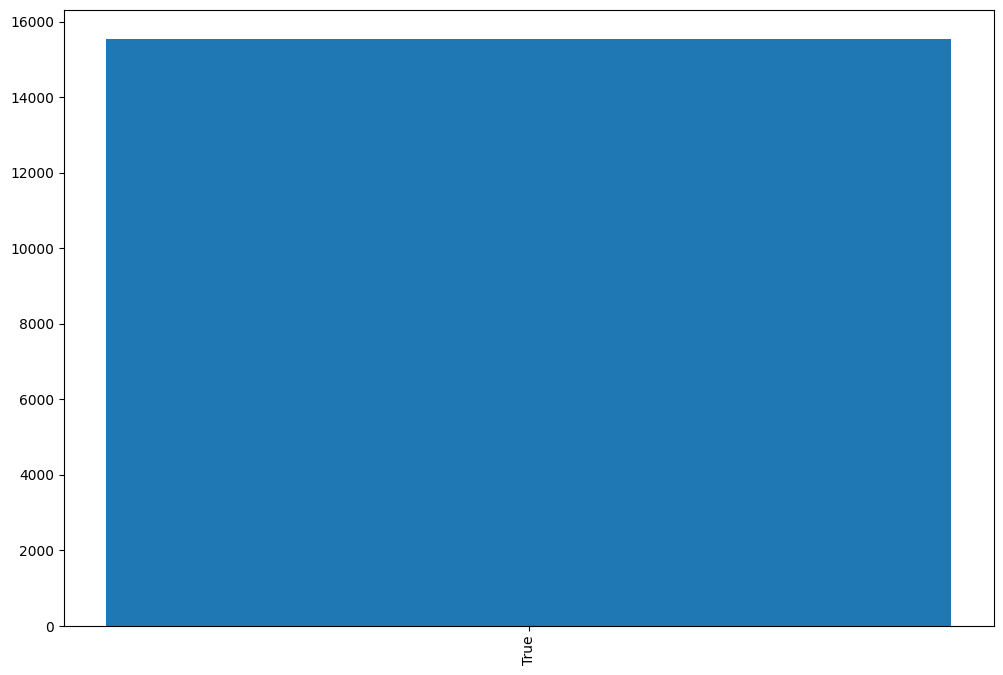

In [ ]:
label_counts = dados_modificados['IMG baixada'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

Após, é interessante criarmos uma nova coluna em nosso cabeçalho de dados para o path da imagem relacionada à doença.

In [ ]:
path = '/content/samples/images/'
dados_modificados['Caminho PNG'] = path + dados_modificados['Image Index']
dados_modificados.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
1  00000001_001.png   Cardiomegaly            1           1           58   
1  00000001_001.png      Emphysema            1           1           58   
2  00000001_002.png   Cardiomegaly            2           1           58   
2  00000001_002.png       Effusion            2           1           58   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2894     2729   
1              M            PA                 2894     2729   
2              M            PA                 2500     2048   
2              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Labels_Count  IMG baixada  \
0                        0.143  0.143             1         True   
1                        0.143  0.143             2         True   
1                        0.143  0.143             2         True   
2                        0.168  0.168             2         True   
2                        0.168  0.168             2         True   

                                Caminho PNG  
0  /content/samples/images/00000001_000.png  
1  /content/samples/images/00000001_001.png  
1  /content/samples/images/00000001_001.png  
2  /content/samples/images/00000001_002.png  
2  /content/samples/images/00000001_002.png

Com isso agora é possível trabalharmos diretamente com as imagens.

/content/samples/images/00000001_000.png
(1024, 1024)


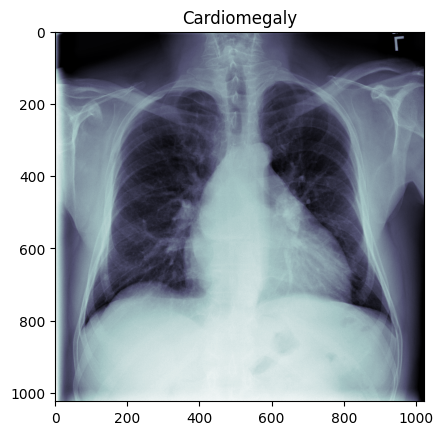

/content/samples/images/00000001_001.png
(1024, 1024)


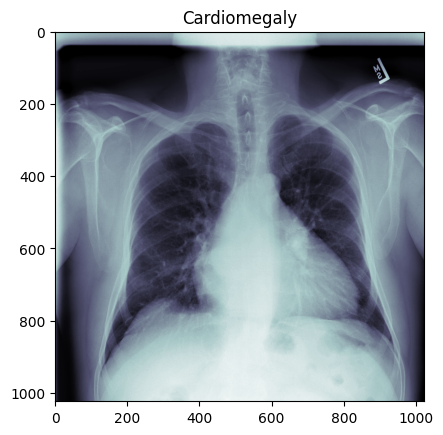

/content/samples/images/00000001_001.png
(1024, 1024)


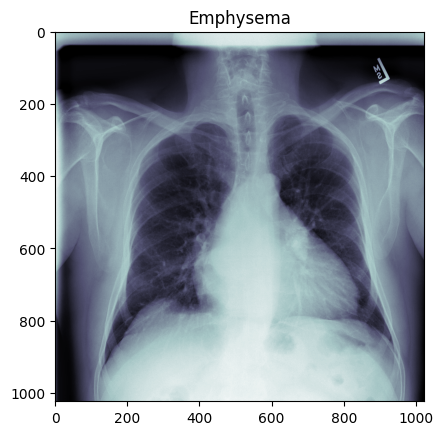

/content/samples/images/00000001_002.png
(1024, 1024)


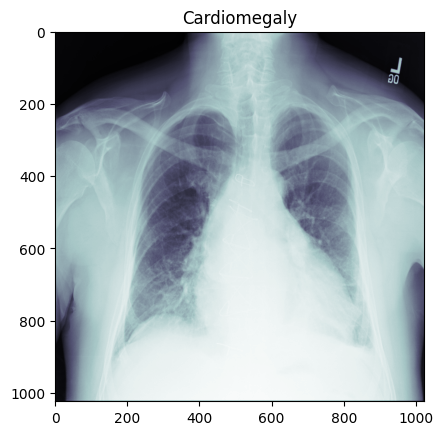

/content/samples/images/00000001_002.png
(1024, 1024)


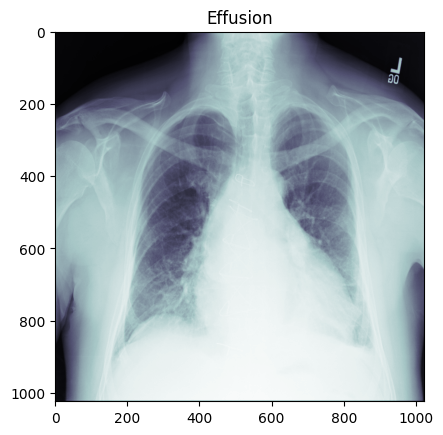

/content/samples/images/00000003_001.png
(1024, 1024)


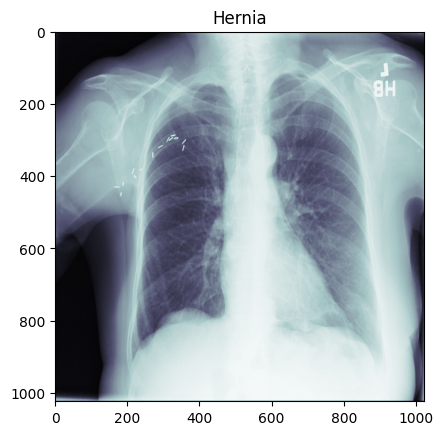

/content/samples/images/00000003_002.png
(1024, 1024)


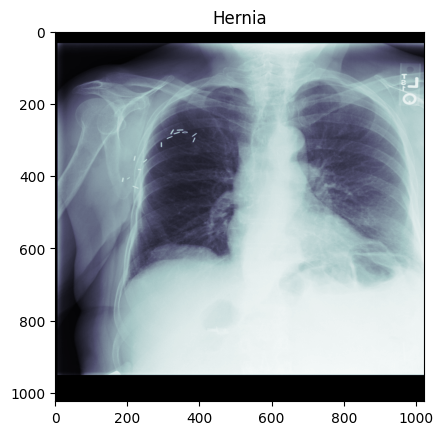

/content/samples/images/00000003_003.png
(1024, 1024)


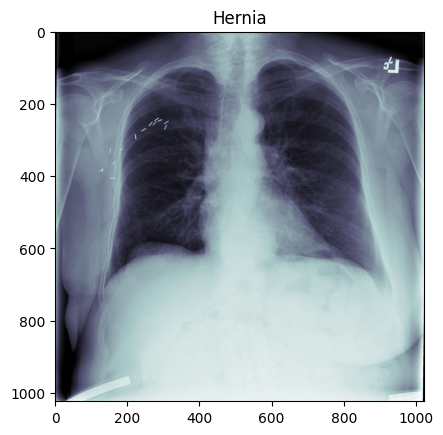

/content/samples/images/00000003_003.png
(1024, 1024)


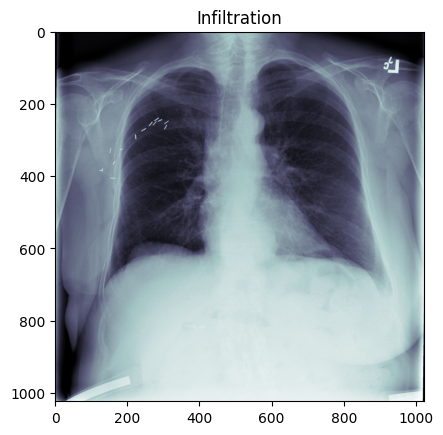

/content/samples/images/00000003_004.png
(1024, 1024)


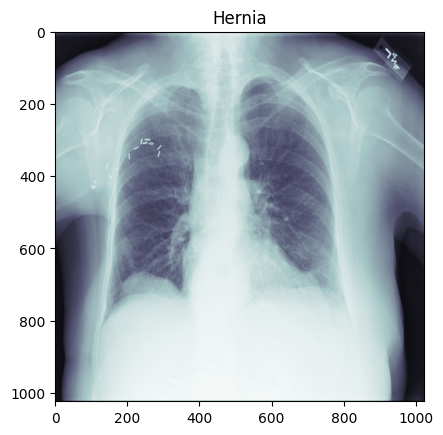

/content/samples/images/00000003_005.png
(1024, 1024)


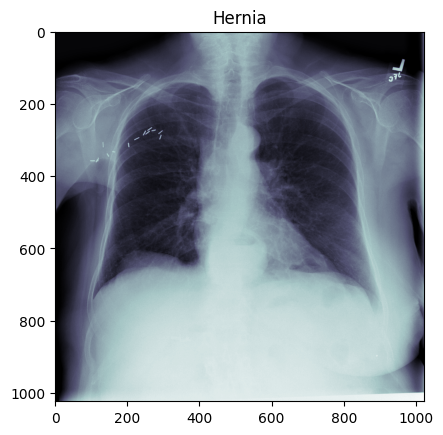

/content/samples/images/00000003_006.png
(1024, 1024)


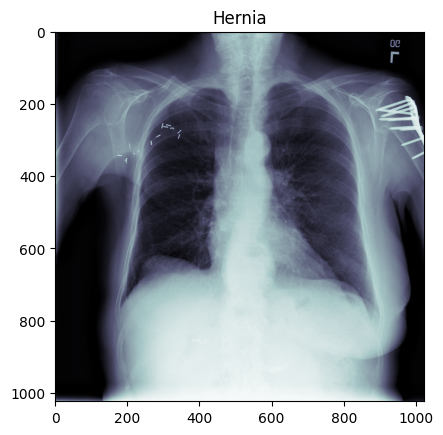

/content/samples/images/00000003_007.png
(1024, 1024)


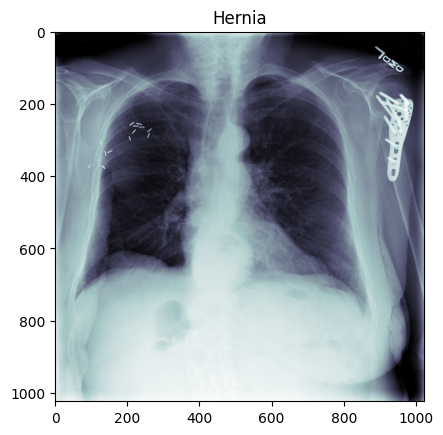

/content/samples/images/00000003_000.png
(1024, 1024)


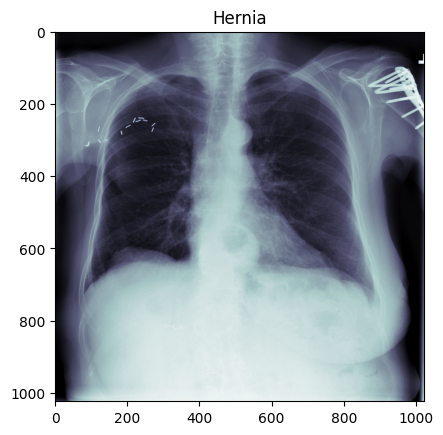

/content/samples/images/00000004_000.png
(1024, 1024, 4)


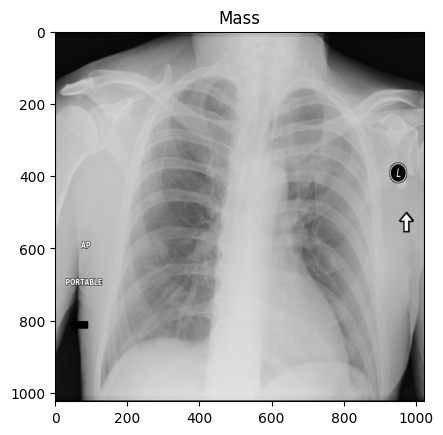

/content/samples/images/00000004_000.png
(1024, 1024, 4)


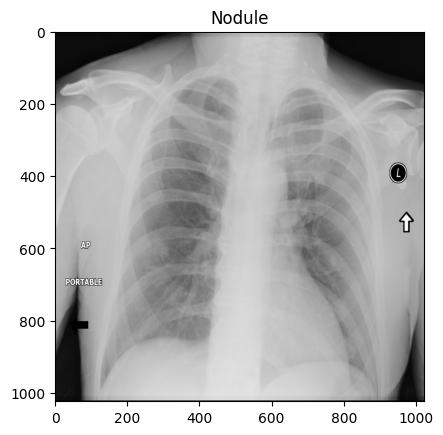

/content/samples/images/00000005_006.png
(1024, 1024)


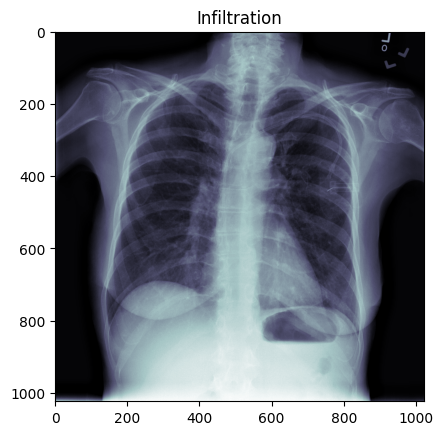

/content/samples/images/00000005_007.png
(1024, 1024)


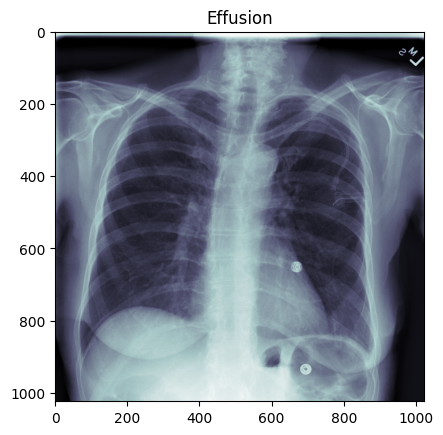

/content/samples/images/00000005_007.png
(1024, 1024)


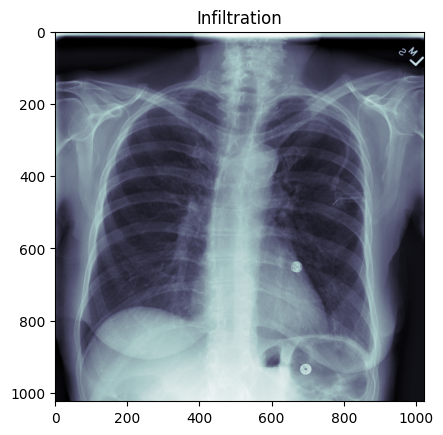

/content/samples/images/00000008_000.png
(1024, 1024)


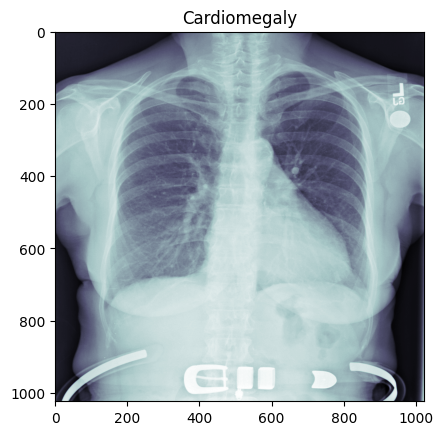

In [ ]:
from skimage import io
index = 0
for i in range(20):
  var = dados_modificados.iloc[index]['Caminho PNG']
  print(var)

  image = io.imread(var)
  print(image.shape)
  plt.imshow(image, cmap = 'bone')
  plt.title(dados_modificados.iloc[index]['Finding Labels'])
  plt.show()
  index+=1

Separar o dataset entre o que iremos utilizar no treinamento e o que iremos utilizar na validação dos modelos.

In [ ]:
import sklearn.model_selection as skl

train_df, test_df = skl.train_test_split(
    dados_modificados,
    test_size = 0.20,
    random_state = 2018,
    stratify = dados_modificados['Finding Labels'].map(lambda x: x[:4]))

In [ ]:
train_df.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
1670   00000457_003.png       Effusion            3         457           34   
9904   00002570_004.png    Atelectasis            4        2570           75   
13557  00003523_023.png   Infiltration           23        3523           23   
2007   00000512_001.png       Effusion            1         512           31   
4583   00001247_007.png   Infiltration            7        1247           43   

      Patient Gender View Position  OriginalImage[Width  Height]  \
1670               M            PA                 2854     2991   
9904               M            AP                 2500     2048   
13557              F            AP                 2500     2048   
2007               M            AP                 2500     2048   
4583               M            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Labels_Count  IMG baixada  \
1670                         0.143  0.143             2         True   
9904                         0.168  0.168             1         True   
13557                        0.168  0.168             2         True   
2007                         0.168  0.168             2         True   
4583                         0.168  0.168             1         True   

                                    Caminho PNG  
1670   /content/samples/images/00000457_003.png  
9904   /content/samples/images/00002570_004.png  
13557  /content/samples/images/00003523_023.png  
2007   /content/samples/images/00000512_001.png  
4583   /content/samples/images/00001247_007.png

In [ ]:
train_df, valid_df = skl.train_test_split(train_df,
    test_size = 0.10,
    random_state = 2018,
    stratify = train_df['Finding Labels'].map(lambda x: x[:4]))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
IMG_SIZE = (224, 224)

core_idg_dense = ImageDataGenerator(rescale=1. / 255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=30)

In [ ]:
def flow_from_dataframe(generator, dataframe, path_col, y_col, target_size, color_mode, batch_size, shuffle=True):
    return generator.flow_from_dataframe(dataframe,
                                         x_col=path_col,
                                         y_col=y_col,
                                         target_size=target_size,
                                         color_mode=color_mode,
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         shuffle=shuffle)

In [ ]:
train_gen = flow_from_dataframe(core_idg_dense, train_df,
                                path_col='Caminho PNG',
                                y_col='Finding Labels',
                                target_size=IMG_SIZE,
                                color_mode='rgb',
                                batch_size=16)

valid_gen = flow_from_dataframe(core_idg_dense, valid_df,
                                path_col='Caminho PNG',
                                y_col='Finding Labels',
                                target_size=IMG_SIZE,
                                color_mode='rgb',
                                batch_size=32,
                                shuffle=False)

test_gen = flow_from_dataframe(core_idg_dense, test_df,
                               path_col='Caminho PNG',
                               y_col='Finding Labels',
                               target_size=IMG_SIZE,
                               color_mode='rgb',
                               batch_size=32,
                               shuffle=False)

test_X, test_Y = next(test_gen)
t_x, t_y = next(train_gen)

Found 11186 validated image filenames belonging to 14 classes.
Found 1243 validated image filenames belonging to 14 classes.
Found 3108 validated image filenames belonging to 14 classes.


Aplicar modelo de tratativa das imagens / classificação.


In [ ]:
labels = dados_modificados['Finding Labels'].unique()
print(labels, labels.size)

['Cardiomegaly' 'Emphysema' 'Effusion' 'Hernia' 'Infiltration' 'Mass'
 'Nodule' 'Atelectasis' 'Pneumothorax' 'Pleural_Thickening' 'Pneumonia'
 'Fibrosis' 'Edema' 'Consolidation'] 14


Modelo 1

In [ ]:
model = keras.Sequential([
    layers.Conv2D(3, (3, 3), activation='relu', padding="same", input_shape=(224,224, 3)),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(14, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 3)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 128)               4817024   
                                                                 
 dense_1 (Dense)             (None, 14)                1806      
                                                                 
Total params: 4818914 (18.38 MB)
Trainable params: 4818914 (18.38 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
from keras import metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['binary_accuracy',metrics.AUC()])

Treinando o modelo

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_gen),
                              epochs=5,
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen))

<ipython-input-28-10a7a02611e5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/5
700/700 [==============================] - 375s 518ms/step - loss: 2.4650 - binary_accuracy: 0.9279 - auc: 0.7228 - val_loss: 2.3017 - val_binary_accuracy: 0.9286 - val_auc: 0.7447
Epoch 2/5
700/700 [==============================] - 332s 474ms/step - loss: 2.3116 - binary_accuracy: 0.9286 - auc: 0.7402 - val_loss: 2.3261 - val_binary_accuracy: 0.9285 - val_auc: 0.7456
Epoch 3/5
700/700 [==============================] - 327s 467ms/step - loss: 2.2932 - binary_accuracy: 0.9286 - auc: 0.7465 - val_loss: 2.2842 - val_binary_accuracy: 0.9286 - val_auc: 0.7485
Epoch 4/5
700/700 [==============================] - 323s 462ms/step - loss: 2.2809 - binary_accuracy: 0.9286 - auc: 0.7510 - val_loss: 2.2838 - val_binary_accuracy: 0.9286 - val_auc: 0.7553
Epoch 5/5
700/700 [==============================] - 326s 465ms/step - loss: 2.2756 - binary_accuracy: 0.9286 - auc: 0.7520 - val_loss: 2.2671 - val_binary_accuracy: 0.9286 - val_auc: 0.7548


Avaliando o modelo

In [ ]:
test_metrics = model.evaluate(test_X, test_Y)
print("Test Loss:", test_metrics[0])
print("Test Accuracy:", test_metrics[1])

1/1 [==============================] - 0s 172ms/step - loss: 2.3651 - binary_accuracy: 0.9286 - auc: 0.7172
Test Loss: 2.365070343017578
Test Accuracy: 0.9285714030265808


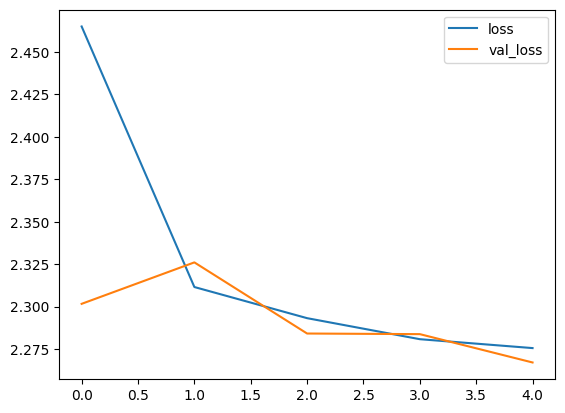

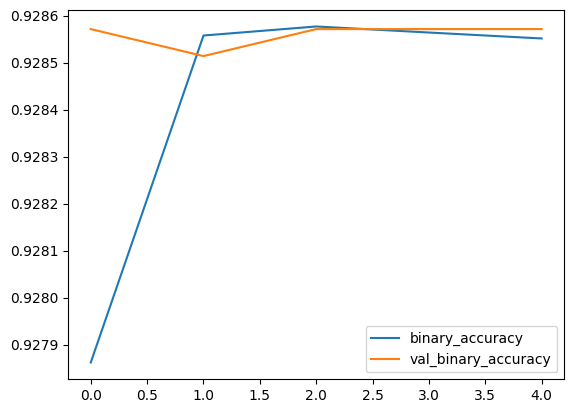

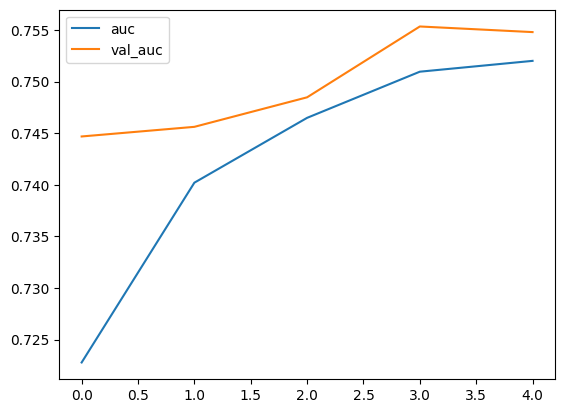

In [ ]:
history_graph = pd.DataFrame(history.history)

history_graph[['loss','val_loss']].plot();
history_graph[['binary_accuracy','val_binary_accuracy']].plot();
history_graph[['auc','val_auc']].plot();

Modelo 2 adicionando uma camada de Dropout.

In [ ]:
from keras.layers import Dropout

model2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(224, 224, 3)),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(14, activation='softmax')
])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['binary_accuracy',metrics.AUC()])

In [ ]:
history = model2.fit(train_gen,
                              steps_per_epoch=len(train_gen),
                              epochs=5,
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen))

Epoch 1/5
700/700 [==============================] - 344s 486ms/step - loss: 2.4950 - binary_accuracy: 0.9280 - auc_1: 0.7106 - val_loss: 2.3182 - val_binary_accuracy: 0.9286 - val_auc_1: 0.7379
Epoch 2/5
700/700 [==============================] - 331s 472ms/step - loss: 2.3430 - binary_accuracy: 0.9286 - auc_1: 0.7277 - val_loss: 2.3229 - val_binary_accuracy: 0.9286 - val_auc_1: 0.7364
Epoch 3/5
700/700 [==============================] - 338s 483ms/step - loss: 2.3282 - binary_accuracy: 0.9286 - auc_1: 0.7327 - val_loss: 2.3241 - val_binary_accuracy: 0.9286 - val_auc_1: 0.7402
Epoch 4/5
700/700 [==============================] - 326s 465ms/step - loss: 2.3190 - binary_accuracy: 0.9286 - auc_1: 0.7347 - val_loss: 2.3137 - val_binary_accuracy: 0.9286 - val_auc_1: 0.7413
Epoch 5/5
700/700 [==============================] - 333s 476ms/step - loss: 2.3195 - binary_accuracy: 0.9286 - auc_1: 0.7345 - val_loss: 2.3098 - val_binary_accuracy: 0.9285 - val_auc_1: 0.7422


In [ ]:
test_metrics = model2.evaluate(test_X, test_Y)
print("Test Loss:", test_metrics[0])
print("Test Accuracy:", test_metrics[1])

1/1 [==============================] - 0s 48ms/step - loss: 2.4168 - binary_accuracy: 0.9286 - auc_1: 0.6927
Test Loss: 2.4168479442596436
Test Accuracy: 0.9285714030265808


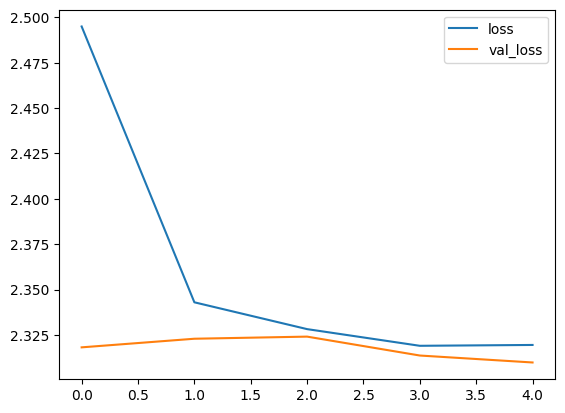

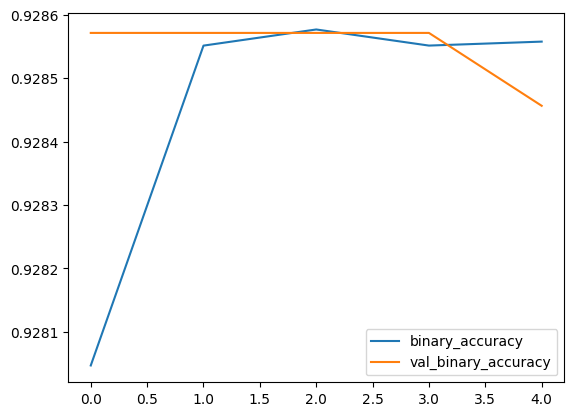

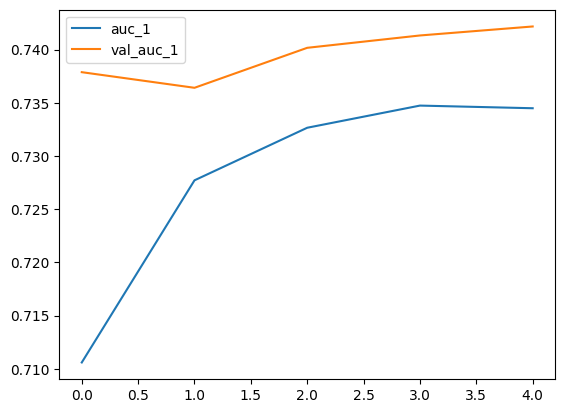

In [ ]:
history_graph = pd.DataFrame(history.history)

history_graph[['loss','val_loss']].plot();
history_graph[['binary_accuracy','val_binary_accuracy']].plot();
history_graph[['auc_1','val_auc_1']].plot();

Modelo 3 com VGG16

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


Congelamento das camadas

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model3 = Sequential()
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(14, activation='softmax'))

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['binary_accuracy',metrics.AUC()])

In [ ]:
history = model3.fit(train_gen,
                              steps_per_epoch=len(train_gen),
                              epochs=5,
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen))

Epoch 1/5
700/700 [==============================] - 352s 499ms/step - loss: 2.3790 - binary_accuracy: 0.9283 - auc_2: 0.7210 - val_loss: 2.3025 - val_binary_accuracy: 0.9286 - val_auc_2: 0.7415
Epoch 2/5
700/700 [==============================] - 337s 481ms/step - loss: 2.3111 - binary_accuracy: 0.9286 - auc_2: 0.7381 - val_loss: 2.2995 - val_binary_accuracy: 0.9286 - val_auc_2: 0.7435
Epoch 3/5
700/700 [==============================] - 338s 483ms/step - loss: 2.3076 - binary_accuracy: 0.9285 - auc_2: 0.7390 - val_loss: 2.3017 - val_binary_accuracy: 0.9286 - val_auc_2: 0.7436
Epoch 4/5
700/700 [==============================] - 343s 490ms/step - loss: 2.2992 - binary_accuracy: 0.9286 - auc_2: 0.7417 - val_loss: 2.2930 - val_binary_accuracy: 0.9286 - val_auc_2: 0.7468
Epoch 5/5
700/700 [==============================] - 334s 478ms/step - loss: 2.2933 - binary_accuracy: 0.9286 - auc_2: 0.7448 - val_loss: 2.2859 - val_binary_accuracy: 0.9286 - val_auc_2: 0.7492


1/1 [==============================] - 0s 190ms/step - loss: 2.4001 - binary_accuracy: 0.9286 - auc_2: 0.7012


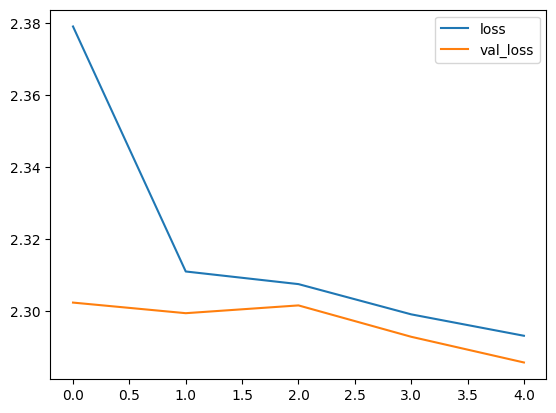

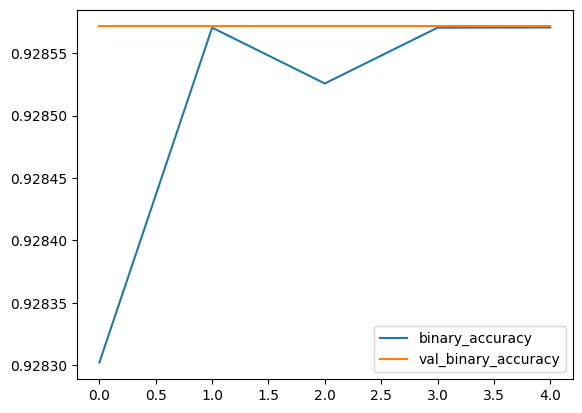

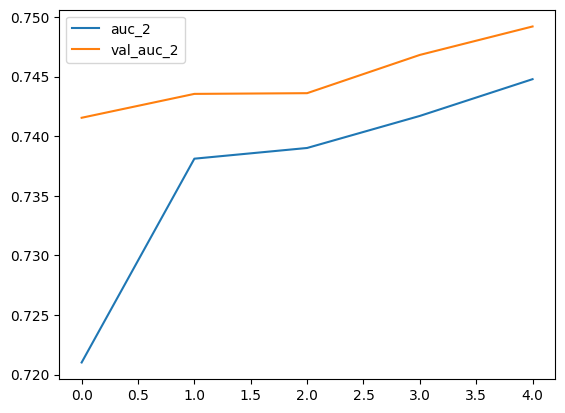

In [ ]:
test_metrics = model3.evaluate(test_X, test_Y)

history_graph = pd.DataFrame(history.history)
history_graph[['loss','val_loss']].plot();
history_graph[['binary_accuracy','val_binary_accuracy']].plot();
history_graph[['auc_2','val_auc_2']].plot();

Ao verificarmos os resultados, observamoos que o modelo mais estável e com os melhores valores no geral foi o primeiro modelo, sendo que ele possuí uma alta acurácia, logo, é um bom modelo a ser seguido.

Apersar disso, é importante tentar seguir reduzindo o valor de loss que o modelo apresentou como forma de melhorar o desempenho.